### Notebook to examine TREFHT skill and differences between DPLE and SMYLE

In [15]:
import xarray as xr
import numpy as np
import sys
import glob
import matplotlib.pyplot as plt
import pandas as pd
import dask
import xesmf as xe

from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars

In [85]:
def detrend_linear(dat, dim):
    """ linear detrend dat along the axis dim """
    params = dat.polyfit(dim=dim, deg=1)
    fit = xr.polyval(dat[dim], params.polyfit_coefficients)
    dat = dat-fit
    return dat

In [86]:
def detrend_quadratic(dat, dim):
    """ quadratic detrending along the axis dim """
    params = dat.polyfit(dim=dim, deg=2)
    fit = xr.polyval(dat[dim], params.polyfit_coefficients)
    dat = dat-fit
    return dat

### Setting up parameters for analysis

In [19]:
ystart = 1970 # start year of hindcasts
yend = 2017 # end year of hindcasts
nyears = yend-ystart+1
initmon = 11 # initialization month
domain = "atm" ; freq="month_1" ; var="TREFHT"
nmems=20 # the number of hindcast members
memstr = [str(i).zfill(3) for i in np.arange(1,nmems+1,1)] # generating member strings
topdir="/glade/campaign/cesm/development/espwg/SMYLE/archive/"
expname="b.e21.BSMYLE.f09_g17"

### Sort out the SMYLE data into an array of the form (init_year, member, time, lat, lon)

In [20]:
for iyear in np.arange(ystart,yend+1,1):
    print(iyear)
    filelist = [glob.glob(topdir+expname+"."+str(iyear)+'-'+str(initmon)+'.'+imem+'/'+domain+'/proc/tseries/'+freq+'/*.'+var+'.*')[0] for imem in memstr]
    dat = xr.open_mfdataset(filelist, combine='nested', concat_dim='M')
    
    # calculate the time_bnd average to fix the CESM calendar
    timebndavg = np.array(dat.time_bnds.isel(M=0),
                         dtype = 'datetime64[s]').view('i8').mean(axis=1).astype('datetime64[s]')
    dat['time'] = timebndavg
    datdjf = cal.season_ts(dat.TREFHT, 'DJF')
    
    # check ensemble size
    if (dat.M.size != nmems):
        print("You do not have "+str(nmems)+" members for year "+str(iyear)+". Aborting...")
        sys.exit()
        
    # check for consistent size of time dimension
    if (iyear > ystart) and (datdjf.time.size != trefht_smyle.time.size):
        print('the size of "time" in year '+str(iyear)+' does not match that of year '+str(ystart)+'. Aborting...')
        sys.exit()
        
    # set up the output arrays
    if (iyear == ystart):
        smyletimes = dat.time # saving times for first member to align ERA5 below
        ntime = datdjf.time.size
        trefht_smyle = xr.DataArray(np.zeros([nyears, nmems, ntime, datdjf.lat.size, datdjf.lon.size]),
                                coords=[np.arange(ystart,yend+1,1), np.arange(1,nmems+1,1), datdjf.time, datdjf.lat, datdjf.lon],
                                dims=['init_year','member','time','lat','lon'], name='trefht_smyle')
        
    # Fill TREFHT output array
    trefht_smyle[iyear-ystart,:,:,:,:] = np.array(datdjf)

1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


### Sort out the DPLE data into the same form as the SMYLE data

In [21]:
nmems = 40 # the number of hindcast members
memstr = [str(i).zfill(3) for i in np.arange(1,nmems+1,1)] # generating member strings

topdirdple = "/glade/campaign/cesm/collections/CESM1-DPLE/atm/proc/tseries/monthly/TREFHT/"
expnamedple="b.e11.BDP.f09_g16"

for iyear in np.arange(ystart, yend+1,1):
    print(iyear)
    filelist = [glob.glob(topdirdple+expnamedple+'.'+str(iyear)+'-11.'+imem+'*')[0] for imem in memstr]
    dat = xr.open_mfdataset(filelist, combine='nested', concat_dim='M')
    
    # calculate the time_bnd average to fix the CESM calendar
    timebndavg = np.array(dat.time_bnds.isel(M=0),
                         dtype = 'datetime64[s]').view('i8').mean(axis=1).astype('datetime64[s]')
    dat['time'] = timebndavg
    datdjf = cal.season_ts(dat.TREFHT, 'DJF')
    datdjf = datdjf.isel(time=slice(0,2))
    
    # check ensemble size
    if (dat.M.size != nmems):
        print("You do not have "+str(nmems)+" members for year "+str(iyear)+". Aborting...")
        sys.exit() 
    
    # set up the output arrays
    if (iyear == ystart):
        trefht_dple = xr.DataArray(np.zeros([nyears,nmems,ntime,datdjfm.lat.size, datdjfm.lon.size]),
                               coords=[np.arange(ystart,yend+1,1), np.arange(1,nmems+1,1), datdjf.time, datdjf.lat, datdjfm.lon],
                                dims=['init_year','member','time','lat','lon'], name='trefht_dple')
        
    trefht_dple[iyear-ystart,:,:,:,:] = np.array(datdjf)

1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


### Observations CRUTS

In [22]:
obsfile="/glade/campaign/cesm/development/espwg/verification_datasets/mon/SAT/cru_ts4.05.1901.2020.tmp.dat.nc"
dat = xr.open_dataset(obsfile).sel(time=slice("1950-01","2020-12"))

# pick out the start and end dates for the smyle hindcasts and calculate the number of years used
starttime = smyletimes.time.isel(time=0) ; endtime = smyletimes.time.isel(time=smyletimes.time.size-1)
nyearshc = (endtime.dt.year - starttime.dt.year).values

# loop through years and fill the obs array
for iyear in np.arange(ystart,yend+1,1):
    print(iyear)
    starttime_obs = str(iyear)+"-"+str(starttime.dt.month.values).zfill(2)
    endtime_obs = str(iyear+nyearshc)+"-"+str(endtime.dt.month.values).zfill(2)
    datuse = dat.sel(time=slice(starttime_obs, endtime_obs))
    datdjf = cal.season_ts(datuse.tmp, 'DJF')
    
    if (iyear == ystart):
        ntime = trefht_smyle.time.size
        trefht_cruts = xr.DataArray(np.zeros([nyears, ntime, datdjf.lat.size, datdjf.lon.size]),
                                  coords = [np.arange(ystart,yend+1,1), datdjf.time, datdjf.lat, datdjf.lon],
                                  dims = ['init_year','time','lat','lon'], name='trefht_cruts')
        
    trefht_cruts[iyear-ystart,:,:,:] = np.array(datdjf[:,:,:])
trefht_cruts = trefht_cruts + 273.15

1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


### Interpolate observed data onto the CESM grid

In [30]:
wgtfile="/glade/scratch/islas/temp/smyle//wgtfile.nc"
grid_out= xr.Dataset({'lat': (['lat'], trefht_smyle.lat)}, {'lon': (['lon'], trefht_smyle.lon)})
regridder = xe.Regridder(trefht_cruts, grid_out, 'bilinear', periodic=True, reuse_weights=False, filename=wgtfile)
trefht_cruts_rg = regridder(trefht_cruts)

/glade/u/home/islas/miniconda3/envs/ecpaperenv/lib/python3.6/site-packages/xarray/core/dataarray.py:745: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/glade/u/home/islas/miniconda3/envs/ecpaperenv/lib/python3.6/site-packages/xesmf/frontend.py:478: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


### remove lead dependent climatologies

In [33]:
# smyle
trefht_smyle_clim = trefht_smyle.mean(['init_year','member'])
trefht_smyle = trefht_smyle - trefht_smyle_clim

# dple
trefht_dple_clim = trefht_dple.mean(['init_year','member'])
trefht_dple = trefht_dple - trefht_dple_clim

# CRUTS 
trefht_cruts_clim = trefht_cruts_rg.mean(['init_year'])
trefht_cruts_rg = trefht_cruts_rg - trefht_cruts_clim

In [62]:
# ensure that the time from initialization axis is the same
trefht_smyle['time'] = np.arange(0,2,1)
trefht_cruts_rg['time'] = np.arange(0,2,1)
trefht_dple['time'] = np.arange(0,2,1)

### Correlation maps

In [58]:
trefht_smyle_em = trefht_smyle.mean("member")
trefht_dple_em = trefht_dple.mean("member")

In [87]:
### linear detrending
trefht_smyle_em_detrend = detrend_linear(trefht_smyle_em, "init_year")
trefht_dple_em_detrend = detrend_linear(trefht_dple_em, "init_year")
trefht_cruts_detrend = detrend_linear(trefht_cruts_rg, "init_year")

trefht_smyle_em_detrendq = detrend_quadratic(trefht_smyle_em, "init_year")
trefht_dple_em_detrendq = detrend_quadratic(trefht_dple_em, "init_year")
trefht_cruts_detrendq = detrend_quadratic(trefht_cruts_rg, "init_year")

In [92]:
test1 = trefht_cruts_rg.isel(time=0)
test2 = trefht_cruts_detrend.isel(time=0)
test3 = trefht_cruts_detrendq.isel(time=0)

In [101]:
## Correlations
trefhtcor_y1_smyle = xr.corr(trefht_smyle_em.isel(time=0), trefht_cruts_rg.isel(time=0), dim='init_year')
trefhtcor_y2_smyle = xr.corr(trefht_smyle_em.isel(time=1), trefht_cruts_rg.isel(time=1), dim='init_year')
trefhtcor_y1_dple = xr.corr(trefht_dple_em.isel(time=0), trefht_cruts_rg.isel(time=0), dim='init_year')
trefhtcor_y2_dple = xr.corr(trefht_dple_em.isel(time=1), trefht_cruts_rg.isel(time=1), dim='init_year')

trefhtcor_y1_smyle_detrend = xr.corr(trefht_smyle_em_detrend.isel(time=0), 
                                     trefht_cruts_detrend.isel(time=0), dim='init_year')
trefhtcor_y2_smyle_detrend = xr.corr(trefht_smyle_em_detrend.isel(time=1), 
                                     trefht_cruts_detrend.isel(time=1), dim='init_year')
trefhtcor_y1_dple_detrend = xr.corr(trefht_dple_em_detrend.isel(time=0), 
                                    trefht_cruts_detrend.isel(time=0), dim='init_year')
trefhtcor_y2_dple_detrend = xr.corr(trefht_dple_em_detrend.isel(time=1), 
                                    trefht_cruts_detrend.isel(time=1), dim='init_year')

trefhtcor_y1_smyle_detrendq = xr.corr(trefht_smyle_em_detrendq.isel(time=0), 
                                     trefht_cruts_detrendq.isel(time=0), dim='init_year')
trefhtcor_y2_smyle_detrendq = xr.corr(trefht_smyle_em_detrendq.isel(time=1), 
                                     trefht_cruts_detrendq.isel(time=1), dim='init_year')
trefhtcor_y1_dple_detrendq = xr.corr(trefht_dple_em_detrendq.isel(time=0), 
                                    trefht_cruts_detrendq.isel(time=0), dim='init_year')
trefhtcor_y2_dple_detrendq = xr.corr(trefht_dple_em_detrendq.isel(time=1), 
                                    trefht_cruts_detrendq.isel(time=1), dim='init_year')

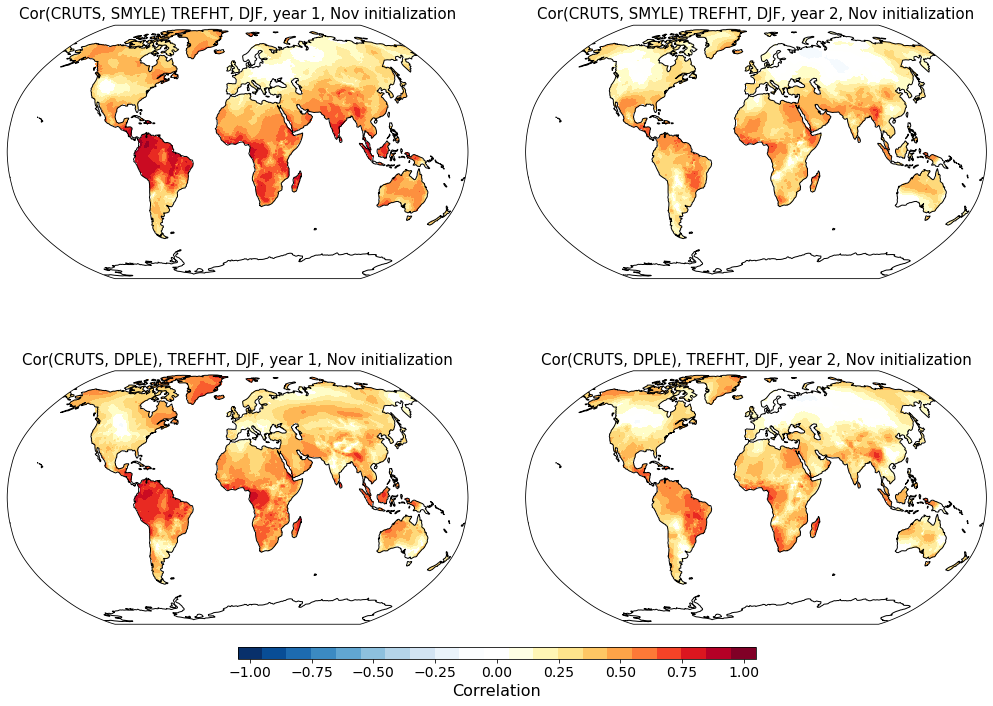

In [112]:
fig = plt.figure(figsize=(16,16))

maps.contourmap_bothoceans_robinson_pos(fig, trefhtcor_y1_smyle, trefhtcor_y1_smyle.lon, trefhtcor_y1_smyle.lat,
                                       0.1,-1,1,'Cor(CRUTS, SMYLE) TREFHT, DJF, year 1, Nov initialization',
                                       0.05,0.45,0.75,0.97)

maps.contourmap_bothoceans_robinson_pos(fig, trefhtcor_y2_smyle, trefhtcor_y2_smyle.lon, trefhtcor_y2_smyle.lat,
                                       0.1,-1,1,'Cor(CRUTS, SMYLE) TREFHT, DJF, year 2, Nov initialization',
                                       0.5,0.9,0.75,0.97)

maps.contourmap_bothoceans_robinson_pos(fig, trefhtcor_y1_dple, trefhtcor_y1_dple.lon, trefhtcor_y1_dple.lat,
                                       0.1,-1,1,'Cor(CRUTS, DPLE), TREFHT, DJF, year 1, Nov initialization',
                                       0.05,0.45,0.45,0.67)

maps.contourmap_bothoceans_robinson_pos(fig, trefhtcor_y2_dple, trefhtcor_y2_dple.lon, trefhtcor_y2_dple.lat,
                                       0.1,-1,1,'Cor(CRUTS, DPLE), TREFHT, DJF, year 2, Nov initialization',
                                       0.5,0.9,0.45,0.67)

cbars.plotcolorbar(fig, 0.1,-1,1,'Correlation',0.25,0.7,0.42,0.43)

fig.savefig('trefht_r.png', bbox_inches='tight', facecolor='white')

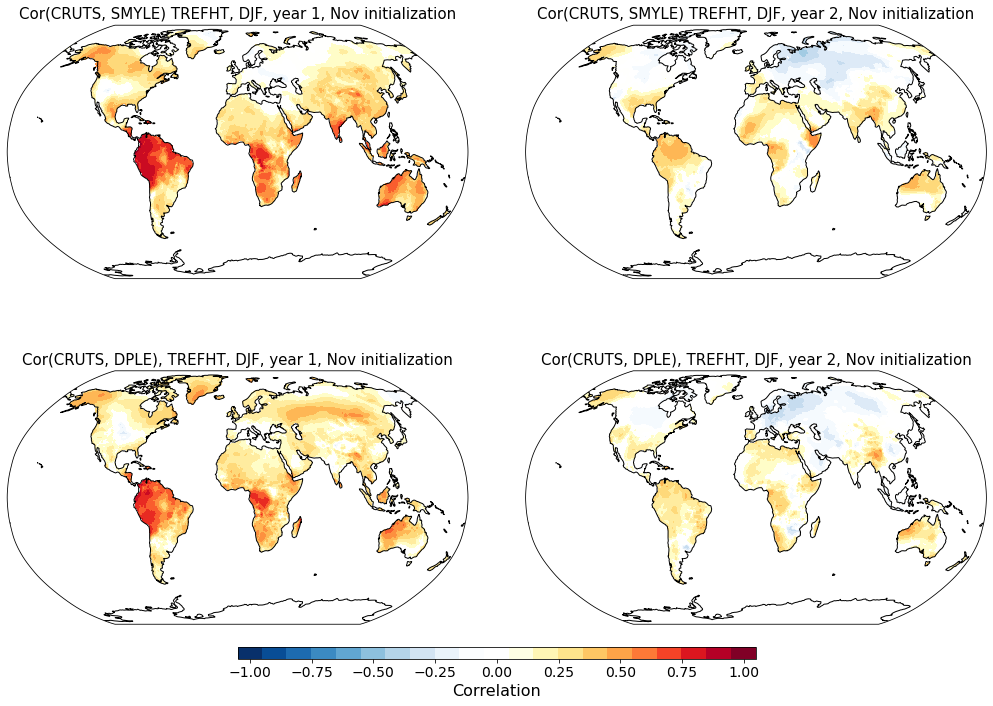

In [113]:
fig = plt.figure(figsize=(16,16))

maps.contourmap_bothoceans_robinson_pos(fig, trefhtcor_y1_smyle_detrend, trefhtcor_y1_smyle.lon, trefhtcor_y1_smyle.lat,
                                       0.1,-1,1,'Cor(CRUTS, SMYLE) TREFHT, DJF, year 1, Nov initialization',
                                       0.05,0.45,0.75,0.97)

maps.contourmap_bothoceans_robinson_pos(fig, trefhtcor_y2_smyle_detrend, trefhtcor_y2_smyle.lon, trefhtcor_y2_smyle.lat,
                                       0.1,-1,1,'Cor(CRUTS, SMYLE) TREFHT, DJF, year 2, Nov initialization',
                                       0.5,0.9,0.75,0.97)

maps.contourmap_bothoceans_robinson_pos(fig, trefhtcor_y1_dple_detrend, trefhtcor_y1_dple.lon, trefhtcor_y1_dple.lat,
                                       0.1,-1,1,'Cor(CRUTS, DPLE), TREFHT, DJF, year 1, Nov initialization',
                                       0.05,0.45,0.45,0.67)

maps.contourmap_bothoceans_robinson_pos(fig, trefhtcor_y2_dple_detrend, trefhtcor_y2_dple.lon, trefhtcor_y2_dple.lat,
                                       0.1,-1,1,'Cor(CRUTS, DPLE), TREFHT, DJF, year 2, Nov initialization',
                                       0.5,0.9,0.45,0.67)

cbars.plotcolorbar(fig, 0.1,-1,1,'Correlation',0.25,0.7,0.42,0.43)

fig.savefig('trefht_r_detrend.png', bbox_inches='tight', facecolor='white')

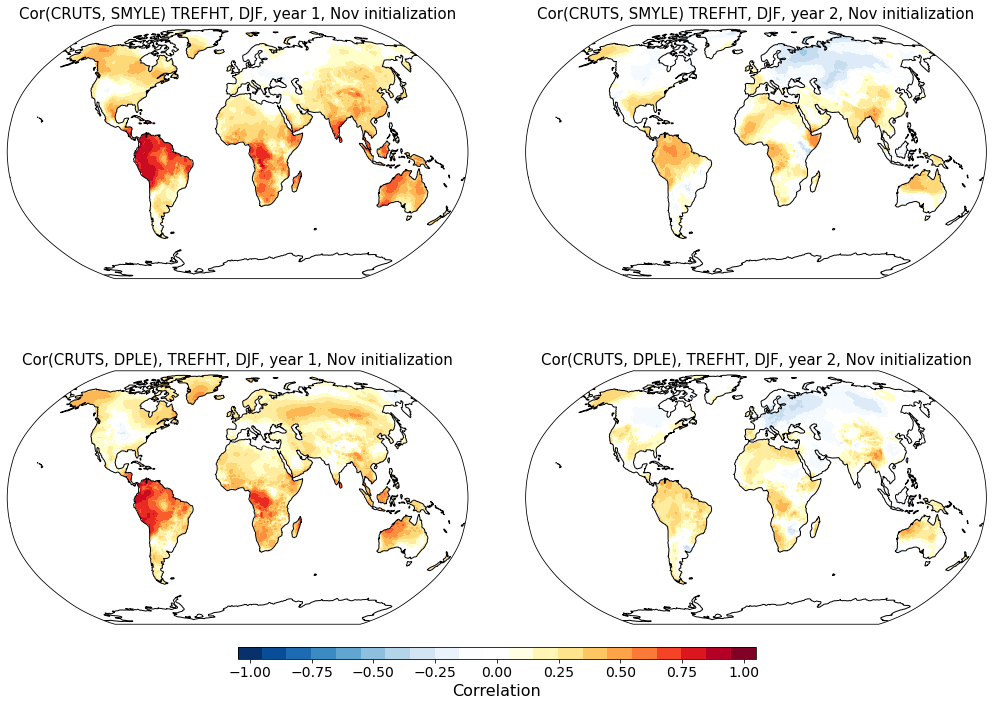

In [114]:
fig = plt.figure(figsize=(16,16))

maps.contourmap_bothoceans_robinson_pos(fig, trefhtcor_y1_smyle_detrendq, trefhtcor_y1_smyle.lon, trefhtcor_y1_smyle.lat,
                                       0.1,-1,1,'Cor(CRUTS, SMYLE) TREFHT, DJF, year 1, Nov initialization',
                                       0.05,0.45,0.75,0.97)

maps.contourmap_bothoceans_robinson_pos(fig, trefhtcor_y2_smyle_detrendq, trefhtcor_y2_smyle.lon, trefhtcor_y2_smyle.lat,
                                       0.1,-1,1,'Cor(CRUTS, SMYLE) TREFHT, DJF, year 2, Nov initialization',
                                       0.5,0.9,0.75,0.97)

maps.contourmap_bothoceans_robinson_pos(fig, trefhtcor_y1_dple_detrendq, trefhtcor_y1_dple.lon, trefhtcor_y1_dple.lat,
                                       0.1,-1,1,'Cor(CRUTS, DPLE), TREFHT, DJF, year 1, Nov initialization',
                                       0.05,0.45,0.45,0.67)

maps.contourmap_bothoceans_robinson_pos(fig, trefhtcor_y2_dple_detrendq, trefhtcor_y2_dple.lon, trefhtcor_y2_dple.lat,
                                       0.1,-1,1,'Cor(CRUTS, DPLE), TREFHT, DJF, year 2, Nov initialization',
                                       0.5,0.9,0.45,0.67)

cbars.plotcolorbar(fig, 0.1,-1,1,'Correlation',0.25,0.7,0.42,0.43)

fig.savefig('trefht_r_detrendq.png', bbox_inches='tight', facecolor='white')

### Normalized mean squared error

In [106]:
error_dple = trefht_dple_em - trefht_cruts_rg
error_smyle = trefht_smyle_em - trefht_cruts_rg
error_obs = trefht_cruts_rg - trefht_cruts_rg.mean('init_year')

error_dple_detrend = trefht_dple_em_detrend - trefht_cruts_detrend
error_smyle_detrend = trefht_smyle_em_detrend - trefht_cruts_detrend
error_obs_detrend = trefht_cruts_detrend - trefht_cruts_detrend.mean('init_year')

error_dple_detrendq = trefht_dple_em_detrendq - trefht_cruts_detrendq
error_smyle_detrendq = trefht_smyle_em_detrendq - trefht_cruts_detrendq
error_obs_detrendq = trefht_cruts_detrendq - trefht_cruts_detrendq.mean('init_year')

In [107]:
mse_dple_y1 = ((error_dple.isel(time=0))**2.).mean('init_year')
mse_smyle_y1 = ((error_smyle.isel(time=0))**2.).mean('init_year')
mse_dple_y2 = ((error_dple.isel(time=1))**2.).mean('init_year')
mse_smyle_y2 = ((error_smyle.isel(time=1))**2.).mean('init_year')
mse_obs_y1 = ((error_obs.isel(time=0)**2.)).mean('init_year')
mse_obs_y2 = ((error_obs.isel(time=1)**2.)).mean('init_year')

mse_dple_y1_detrend = ((error_dple_detrend.isel(time=0))**2.).mean('init_year')
mse_smyle_y1_detrend = ((error_smyle_detrend.isel(time=0))**2.).mean('init_year')
mse_dple_y2_detrend = ((error_dple_detrend.isel(time=1))**2.).mean('init_year')
mse_smyle_y2_detrend = ((error_smyle_detrend.isel(time=1))**2.).mean('init_year')
mse_obs_y1_detrend = ((error_obs_detrend.isel(time=0)**2.)).mean('init_year')
mse_obs_y2_detrend = ((error_obs_detrend.isel(time=1)**2.)).mean('init_year')

mse_dple_y1_detrendq = ((error_dple_detrendq.isel(time=0))**2.).mean('init_year')
mse_smyle_y1_detrendq = ((error_smyle_detrendq.isel(time=0))**2.).mean('init_year')
mse_dple_y2_detrendq = ((error_dple_detrendq.isel(time=1))**2.).mean('init_year')
mse_smyle_y2_detrendq = ((error_smyle_detrendq.isel(time=1))**2.).mean('init_year')
mse_obs_y1_detrendq = ((error_obs_detrendq.isel(time=0)**2.)).mean('init_year')
mse_obs_y2_detrendq = ((error_obs_detrendq.isel(time=1)**2.)).mean('init_year')

In [108]:
msss_dple_y1 = 1. - (mse_dple_y1/mse_obs_y1)
msss_dple_y2 = 1. - (mse_dple_y2/mse_obs_y2)
msss_smyle_y1 = 1. - (mse_smyle_y1/mse_obs_y1)
msss_smyle_y2 = 1. - (mse_smyle_y2/mse_obs_y2)

msss_dple_y1_detrend = 1. - (mse_dple_y1_detrend/mse_obs_y1_detrend)
msss_dple_y2_detrend = 1. - (mse_dple_y2_detrend/mse_obs_y2_detrend)
msss_smyle_y1_detrend = 1. - (mse_smyle_y1_detrend/mse_obs_y1_detrend)
msss_smyle_y2_detrend = 1. - (mse_smyle_y2_detrend/mse_obs_y2_detrend)

msss_dple_y1_detrendq = 1. - (mse_dple_y1_detrendq/mse_obs_y1_detrendq)
msss_dple_y2_detrendq = 1. - (mse_dple_y2_detrendq/mse_obs_y2_detrendq)
msss_smyle_y1_detrendq = 1. - (mse_smyle_y1_detrendq/mse_obs_y1_detrendq)
msss_smyle_y2_detrendq = 1. - (mse_smyle_y2_detrendq/mse_obs_y2_detrendq)

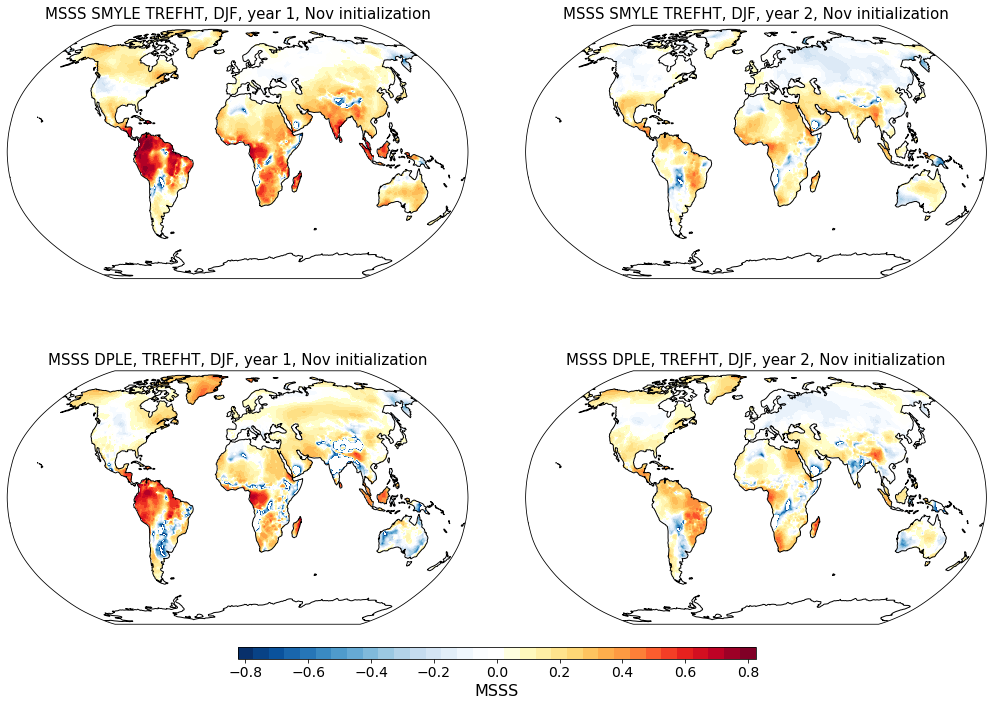

In [115]:
fig = plt.figure(figsize=(16,16))

maps.contourmap_bothoceans_robinson_pos(fig, msss_smyle_y1, trefhtcor_y1_smyle.lon, trefhtcor_y1_smyle.lat,
                                       0.05,-0.8,0.8,'MSSS SMYLE TREFHT, DJF, year 1, Nov initialization',
                                       0.05,0.45,0.75,0.97)

maps.contourmap_bothoceans_robinson_pos(fig, msss_smyle_y2, trefhtcor_y2_smyle.lon, trefhtcor_y2_smyle.lat,
                                       0.05,-0.8,0.8,'MSSS SMYLE TREFHT, DJF, year 2, Nov initialization',
                                       0.5,0.9,0.75,0.97)

maps.contourmap_bothoceans_robinson_pos(fig, msss_dple_y1, trefhtcor_y1_dple.lon, trefhtcor_y1_dple.lat,
                                       0.05,-0.8,0.8,'MSSS DPLE, TREFHT, DJF, year 1, Nov initialization',
                                       0.05,0.45,0.45,0.67)

maps.contourmap_bothoceans_robinson_pos(fig, msss_dple_y2, trefhtcor_y2_dple.lon, trefhtcor_y2_dple.lat,
                                       0.05,-0.8,0.8,'MSSS DPLE, TREFHT, DJF, year 2, Nov initialization',
                                       0.5,0.9,0.45,0.67)

cbars.plotcolorbar(fig, 0.05,-0.8,0.8,'MSSS',0.25,0.7,0.42,0.43)

fig.savefig('trefht_msss.png', bbox_inches='tight', facecolor='white')

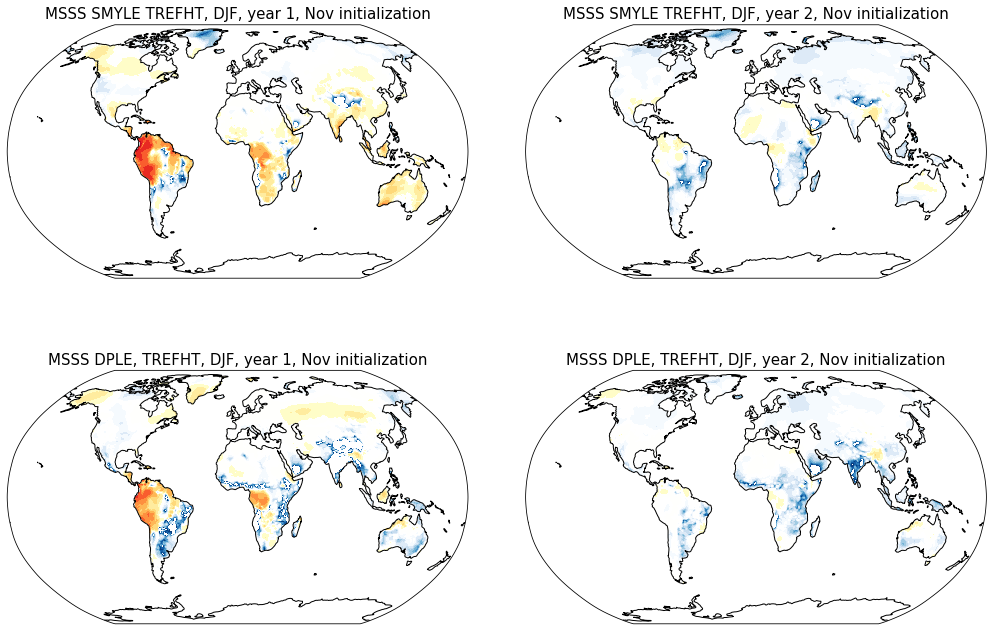

In [110]:
fig = plt.figure(figsize=(16,16))

maps.contourmap_bothoceans_robinson_pos(fig, msss_smyle_y1_detrend, trefhtcor_y1_smyle.lon, trefhtcor_y1_smyle.lat,
                                       0.05,-0.8,0.8,'MSSS SMYLE TREFHT, DJF, year 1, Nov initialization',
                                       0.05,0.45,0.75,0.97)

maps.contourmap_bothoceans_robinson_pos(fig, msss_smyle_y2_detrend, trefhtcor_y2_smyle.lon, trefhtcor_y2_smyle.lat,
                                       0.1,-1,1,'MSSS SMYLE TREFHT, DJF, year 2, Nov initialization',
                                       0.5,0.9,0.75,0.97)

maps.contourmap_bothoceans_robinson_pos(fig, msss_dple_y1_detrend, trefhtcor_y1_dple.lon, trefhtcor_y1_dple.lat,
                                       0.1,-1,1,'MSSS DPLE, TREFHT, DJF, year 1, Nov initialization',
                                       0.05,0.45,0.45,0.67)

maps.contourmap_bothoceans_robinson_pos(fig, msss_dple_y2_detrend, trefhtcor_y2_dple.lon, trefhtcor_y2_dple.lat,
                                       0.1,-1,1,'MSSS DPLE, TREFHT, DJF, year 2, Nov initialization',
                                       0.5,0.9,0.45,0.67)

fig.savefig('trefht_msss_detrend.png', bbox_inches='tight', facecolor='white')

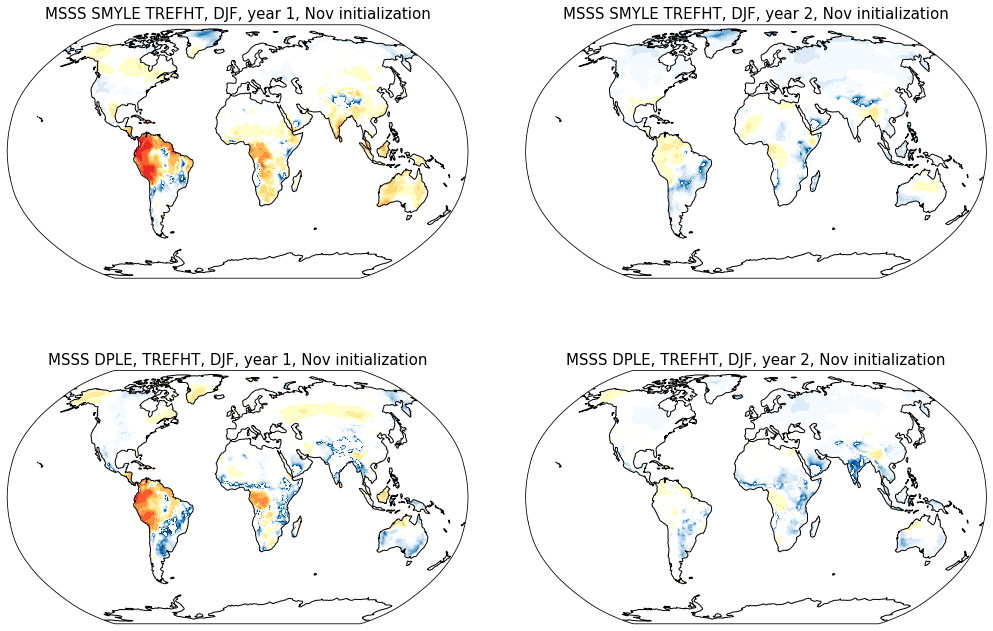

In [111]:
fig = plt.figure(figsize=(16,16))

maps.contourmap_bothoceans_robinson_pos(fig, msss_smyle_y1_detrendq, trefhtcor_y1_smyle.lon, trefhtcor_y1_smyle.lat,
                                       0.1,-1,1,'MSSS SMYLE TREFHT, DJF, year 1, Nov initialization',
                                       0.05,0.45,0.75,0.97)

maps.contourmap_bothoceans_robinson_pos(fig, msss_smyle_y2_detrendq, trefhtcor_y2_smyle.lon, trefhtcor_y2_smyle.lat,
                                       0.1,-1,1,'MSSS SMYLE TREFHT, DJF, year 2, Nov initialization',
                                       0.5,0.9,0.75,0.97)

maps.contourmap_bothoceans_robinson_pos(fig, msss_dple_y1_detrendq, trefhtcor_y1_dple.lon, trefhtcor_y1_dple.lat,
                                       0.1,-1,1,'MSSS DPLE, TREFHT, DJF, year 1, Nov initialization',
                                       0.05,0.45,0.45,0.67)

maps.contourmap_bothoceans_robinson_pos(fig, msss_dple_y2_detrendq, trefhtcor_y2_dple.lon, trefhtcor_y2_dple.lat,
                                       0.1,-1,1,'MSSS DPLE, TREFHT, DJF, year 2, Nov initialization',
                                       0.5,0.9,0.45,0.67)

fig.savefig('trefht_msss_detrendq.png', bbox_inches='tight', facecolor='white')

In [48]:
print(trefht_dple_em)

<xarray.DataArray 'trefht_dple' (init_year: 48, time: 2, lat: 192, lon: 288)>
array([[[[-0.3920773 , -0.38566198, -0.38825562, ..., -0.38595479,
          -0.3926753 , -0.37928471],
         [-0.64968998, -0.64984851, -0.55697814, ..., -0.5811843 ,
          -0.642619  , -0.63174904],
         [-0.67732529, -0.67818985, -0.68492993, ..., -0.67798276,
          -0.69314192, -0.67704176],
         ...,
         [-1.05818423, -1.0591318 , -1.06010476, ..., -1.05608753,
          -1.05671239, -1.05735133],
         [-1.07428192, -1.07439992, -1.07452079, ..., -1.07403347,
          -1.07412084, -1.07419456],
         [-1.08571153, -1.08570422, -1.08570191, ..., -1.08572537,
          -1.08571853, -1.08571334]],

        [[-0.44392887, -0.44083554, -0.44462969, ..., -0.43747296,
          -0.44337914, -0.44556801],
         [-0.64942618, -0.64940804, -0.5655268 , ..., -0.57288011,
          -0.64166152, -0.62685097],
         [-0.66637429, -0.67125342, -0.67494481, ..., -0.66902723,
       